In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [74]:
df = pd.read_csv('day.csv')

In [75]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


> "cnt" column is our target column

In [76]:
df.shape

(730, 16)

In [77]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## Data Cleaning 

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [79]:
# we don't need 'instance' additional index
# we don't need exact dates as yr, month and day column exist
# since we have total count, "casual" and "registered" count can be dropped 
df.drop(columns=['instant','dteday','casual','registered'],inplace=True)

In [80]:
df.drop_duplicates(inplace=True)
df.shape # no duplicates found

(730, 12)

In [81]:
# checking null rows
df.isna().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

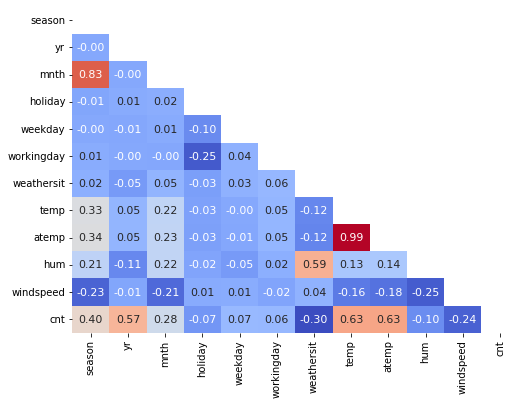

In [82]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm',
            mask=mask,cbar=False,annot_kws={"size":11})

plt.show()

- positively and highly correlated columns with target ( count of bikes )  - 
   - season 
   - year
   - temp
   - atemp ( feels like temp )
- Negetively correlated columns with target - 
   - weather situation
   - windspeed

let's split data into categorical and numerical variables for analysis 

In [83]:
df.iloc[:,7:]#.columns.to_list()

,temp,atemp,hum,windspeed,cnt
0,14.110847,18.18125,80.5833,10.749882,985
1,14.902598,17.68695,69.6087,16.652113,801
2,8.050924,9.47025,43.7273,16.636703,1349
3,8.200000,10.60610,59.0435,10.739832,1562
4,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...
725,10.420847,11.33210,65.2917,23.458911,2114
726,10.386653,12.75230,59.0000,10.416557,3095
727,10.386653,12.12000,75.2917,8.333661,1341
728,10.489153,11.58500,48.3333,23.500518,1796


In [84]:
categorical_cols = df.iloc[:,:7].columns.to_list() # first 7 columns are categorical
print(f"Categorical Columns   : {categorical_cols}")
numerical_cols = df.iloc[:,7:].columns.to_list() # rest of them are numeric 
print(f"Numeric Columns       : {numerical_cols}")


Categorical Columns   : ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Numeric Columns       : ['temp', 'atemp', 'hum', 'windspeed', 'cnt']


Visualising Numeric Variables using a pairplot

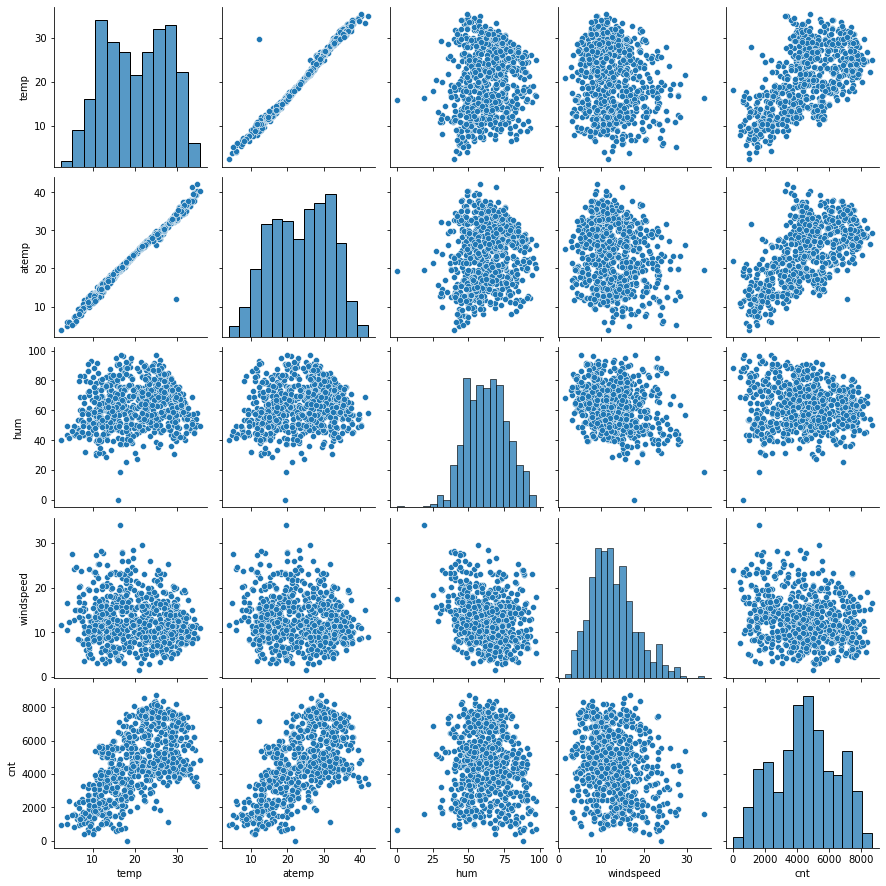

In [85]:
sns.pairplot(data=df,vars=numerical_cols)

- atemp ("feels like" temperature) and target are positively correlated ( also seen in corr matrix)
- temp and target are also correlated 
- Hence we can use a linear model 

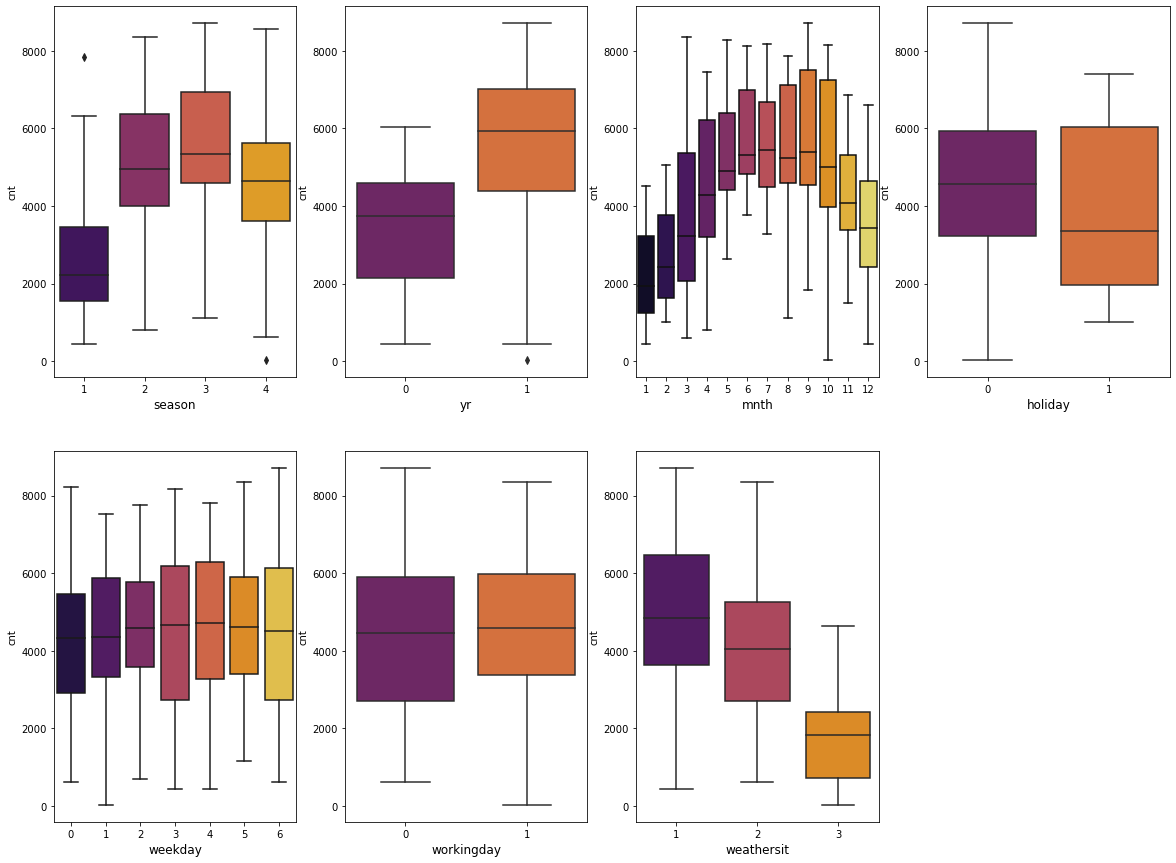

In [86]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_cols, start=1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=col, y='cnt', data=df,palette='inferno')
    plt.xlabel(col, fontsize=12) 
plt.show()

- "Season"  : summer and fall  have high medians  
- "Year"    : 2019 has higher count than 2018 
- "Month"   : as summer and fall have high counts , months starting April upto November have high counts
- "Holiday" : Workday has higher count 
- Weather situation  : People prefer bikes if weather is Clear, Few clouds, Partly cloudy, Partly cloudy 

### for each variable , let's create columns for each level

In [87]:
for i in categorical_cols:
   df[i] = df[i].astype(str)

In [88]:
dummy = pd.get_dummies(df[categorical_cols] ,drop_first=True)

In [89]:
df = pd.concat([dummy,df[numerical_cols]],axis=1)
df

,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,mnth_12,mnth_2,mnth_3,mnth_4,...,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3,temp,atemp,hum,windspeed,cnt
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,14.110847,18.18125,80.5833,10.749882,985
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,14.902598,17.68695,69.6087,16.652113,801
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,8.050924,9.47025,43.7273,16.636703,1349
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,8.200000,10.60610,59.0435,10.739832,1562
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0,0,0,1,0,0,1,0,0,0,...,0,0,1,1,0,10.420847,11.33210,65.2917,23.458911,2114
726,0,0,0,1,0,0,1,0,0,0,...,1,0,1,1,0,10.386653,12.75230,59.0000,10.416557,3095
727,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,10.386653,12.12000,75.2917,8.333661,1341
728,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,10.489153,11.58500,48.3333,23.500518,1796


In [90]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.7, random_state=100)

# Scaling numeric features

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols]) 

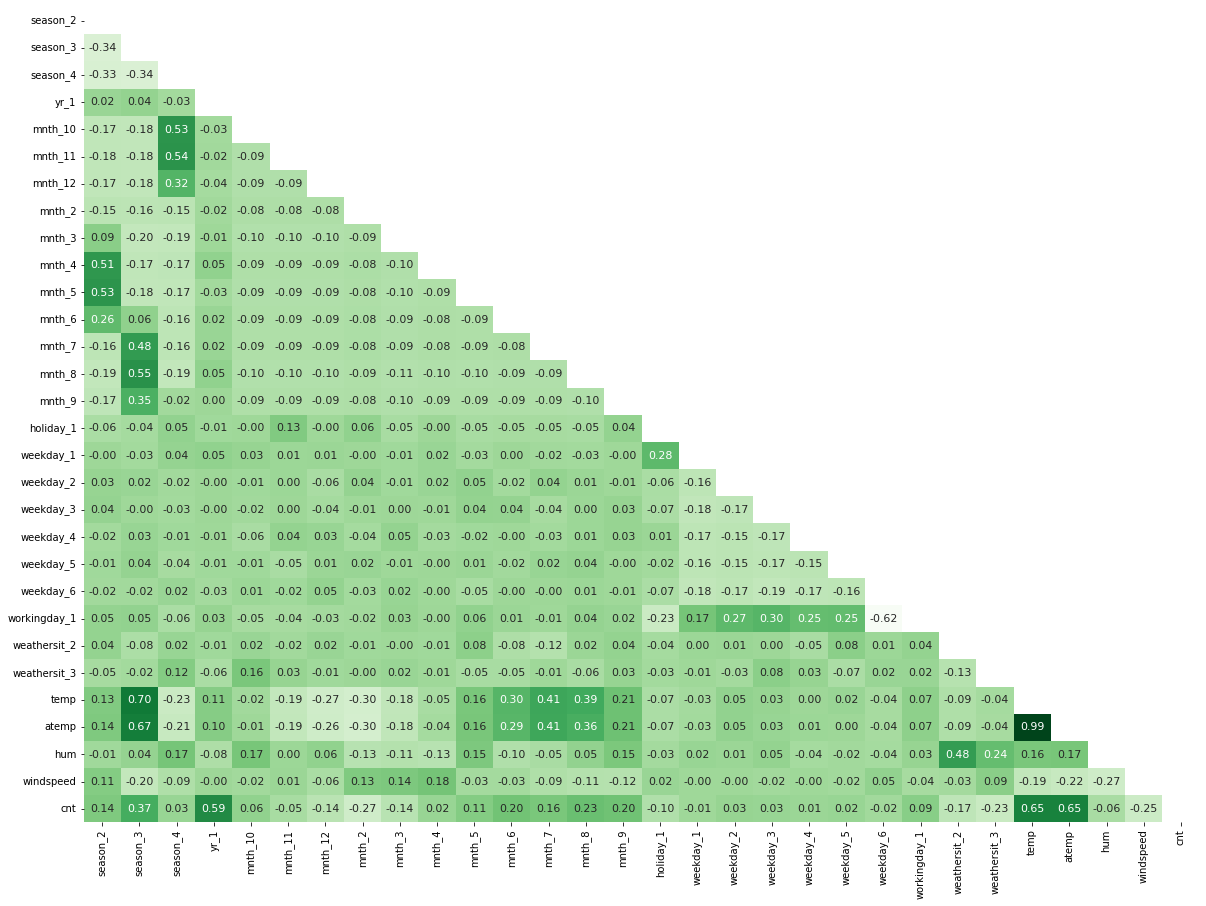

In [92]:
mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))

plt.figure(figsize=(20,15))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap='Greens',
            mask=mask,cbar=False,annot_kws={"size":11})

plt.show()

In [93]:
y_train = df_train.pop('cnt')
X_train = df_train

### We will use Recursive Feature Elimination to find top 15 important feautures

In [94]:
def get_VIF(df):
    VIF_df = pd.DataFrame()
    VIF_df['features'] = df.columns
    VIF_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    VIF_df = VIF_df.sort_values(by='VIF', ascending=False)
    VIF_df = VIF_df.reset_index(drop=True)
    return VIF_df

## Fitting Data to linear model

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm

lm = LinearRegression()
lm.fit(X_train, y_train)

# select the top 15 features using RFE
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

rfe_df = pd.DataFrame({'Column': X_train.columns, 
                       'Ranking': rfe.ranking_})\
                          .sort_values(by='Ranking').reset_index(drop=True)

# select only those columns that were chosen by RFE
col_list = X_train.columns[rfe.support_]

# create a new training dataset with only the selected features
X_train_rfe = X_train[col_list]

# Add a constant term to the training data
X_train_sm = sm.add_constant(X_train_rfe)

# fit ordinary least Squares (OLS) using statsmodels
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
display(lr_model.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          5.17e-191
Time:                        14:04:11   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1952      0.029      6.790      0.000       0.139       0.252
season_2         0.1183      0.015      8.038      0.000       0.089       0.147
season_3         0.0292      0.022      1.329      0.184      -0.014       0.072
season_4         0.1430      0.013     10.671      0.000       0.117       0.169
yr_1             0.2301      0.008     28.743      0.000       0.214       0.246
mnth_10          0.0416      0.017      2.391      0.017       0.007       0.076
mnth_8           0.0473      0.017      2.732      0.007       0.013       0.081
mnth_9           0.1176      0.017      6.876      0.000       0.084       0.151
holiday_1       -0.0545      0.027     -2.025      0.043      -0.107      -0.002
weekday_6        0.0531      0.015      3.655      0.000       0.025       0.082
workingday_1     0.0445      0.012      3.856      0.000       0.022       0.067
weathersit_2    -0.0577      0.010     -5.564      0.000      -0.078      -0.037
weathersit_3    -0.2507      0.026     -9.579      0.000      -0.302      -0.199
temp             0.4972      0.034     14.821      0.000       0.431       0.563
hum             -0.1639      0.037     -4.395      0.000      -0.237      -0.091
windspeed       -0.1825      0.025     -7.196      0.000      -0.232      -0.133
==============================================================================
Omnibus:                       76.225   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.955
Skew:                          -0.743   Prob(JB):                     1.40e-44
Kurtosis:                       5.701   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- P value of "season_3" column is gt 0.05, hence dropping it and modelling again

In [96]:
col_list = col_list.drop(['season_3'])
X_train_rfe = X_train[col_list]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
display(lr_model.summary())

print("\n========VIF table======\n")
get_VIF(X_train_rfe)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          8.70e-192
Time:                        14:04:18   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1948      0.029      6.769      0.000       0.138       0.251
season_2         0.1049      0.011      9.778      0.000       0.084       0.126
season_4         0.1349      0.012     11.306      0.000       0.111       0.158
yr_1             0.2292      0.008     28.712      0.000       0.214       0.245
mnth_10          0.0385      0.017      2.230      0.026       0.005       0.072
mnth_8           0.0557      0.016      3.457      0.001       0.024       0.087
mnth_9           0.1252      0.016      7.757      0.000       0.093       0.157
holiday_1       -0.0557      0.027     -2.069      0.039      -0.109      -0.003
weekday_6        0.0527      0.015      3.627      0.000       0.024       0.081
workingday_1     0.0442      0.012      3.829      0.000       0.022       0.067
weathersit_2    -0.0568      0.010     -5.482      0.000      -0.077      -0.036
weathersit_3    -0.2470      0.026     -9.484      0.000      -0.298      -0.196
temp             0.5309      0.022     24.146      0.000       0.488       0.574
hum             -0.1708      0.037     -4.620      0.000      -0.243      -0.098
windspeed       -0.1858      0.025     -7.353      0.000      -0.235      -0.136
==============================================================================
Omnibus:                       70.710   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.743
Skew:                          -0.710   Prob(JB):                     4.18e-39
Kurtosis:                       5.511   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


========VIF table======



,features,VIF
0,hum,16.565546
1,temp,10.014134
2,workingday_1,5.050642
3,windspeed,3.826064
4,season_4,2.252632
5,weathersit_2,2.138856
6,yr_1,2.026841
7,weekday_6,1.903896
8,season_2,1.835474
9,mnth_10,1.606809


- In the VIF table, we see that Humidity column seems to be explained by some other feature. So we will again drop this humidity feature and design our model.

In [97]:
col_list = col_list.drop(['hum'])
X_train_rfe = X_train[col_list]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
display(lr_model.summary())

print("\n========VIF table======\n")
get_VIF(X_train_rfe)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          1.97e-188
Time:                        14:04:28   Log-Likelihood:                 507.76
No. Observations:                 510   AIC:                            -987.5
Df Residuals:                     496   BIC:                            -928.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0937      0.019      4.914      0.000       0.056       0.131
season_2         0.1019      0.011      9.325      0.000       0.080       0.123
season_4         0.1267      0.012     10.524      0.000       0.103       0.150
yr_1             0.2331      0.008     28.769      0.000       0.217       0.249
mnth_10          0.0343      0.018      1.950      0.052      -0.000       0.069
mnth_8           0.0539      0.016      3.281      0.001       0.022       0.086
mnth_9           0.1185      0.016      7.226      0.000       0.086       0.151
holiday_1       -0.0541      0.027     -1.971      0.049      -0.108      -0.000
weekday_6        0.0578      0.015      3.912      0.000       0.029       0.087
workingday_1     0.0473      0.012      4.026      0.000       0.024       0.070
weathersit_2    -0.0840      0.009     -9.676      0.000      -0.101      -0.067
weathersit_3    -0.2929      0.025    -11.930      0.000      -0.341      -0.245
temp             0.5106      0.022     23.229      0.000       0.467       0.554
windspeed       -0.1530      0.025     -6.183      0.000      -0.202      -0.104
==============================================================================
Omnibus:                       69.409   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.594
Skew:                          -0.699   Prob(JB):                     3.32e-38
Kurtosis:                       5.484   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


========VIF table======



,features,VIF
0,temp,6.391172
1,workingday_1,4.399107
2,windspeed,3.600755
3,yr_1,2.022670
4,season_4,1.999887
5,season_2,1.829537
6,weekday_6,1.771836
7,mnth_10,1.604697
8,mnth_8,1.593079
9,weathersit_2,1.546066


- The "month_10" feature has p-value more than 0.05 hence dropping it

In [98]:
col_list = col_list.drop(['mnth_10'])
X_train_rfe = X_train[col_list]
X_train_sm = sm.add_constant(X_train_rfe)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
display(lr_model.summary())

print("\n========VIF table======\n")
get_VIF(X_train_rfe)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.0
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          8.64e-189
Time:                        14:04:50   Log-Likelihood:                 505.81
No. Observations:                 510   AIC:                            -985.6
Df Residuals:                     497   BIC:                            -930.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0903      0.019      4.740      0.000       0.053       0.128
season_2         0.1004      0.011      9.183      0.000       0.079       0.122
season_4         0.1382      0.011     13.148      0.000       0.118       0.159
yr_1             0.2327      0.008     28.651      0.000       0.217       0.249
mnth_8           0.0510      0.016      3.104      0.002       0.019       0.083
mnth_9           0.1136      0.016      6.991      0.000       0.082       0.146
holiday_1       -0.0560      0.028     -2.036      0.042      -0.110      -0.002
weekday_6        0.0569      0.015      3.842      0.000       0.028       0.086
workingday_1     0.0463      0.012      3.933      0.000       0.023       0.069
weathersit_2    -0.0830      0.009     -9.555      0.000      -0.100      -0.066
weathersit_3    -0.2872      0.024    -11.749      0.000      -0.335      -0.239
temp             0.5188      0.022     23.980      0.000       0.476       0.561
windspeed       -0.1508      0.025     -6.085      0.000      -0.200      -0.102
==============================================================================
Omnibus:                       61.225   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.277
Skew:                          -0.644   Prob(JB):                     2.10e-31
Kurtosis:                       5.234   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


========VIF table======



,features,VIF
0,temp,6.204144
1,workingday_1,4.352707
2,windspeed,3.600658
3,yr_1,2.019785
4,season_2,1.819367
5,weekday_6,1.762102
6,mnth_8,1.581832
7,weathersit_2,1.543814
8,season_4,1.521330
9,mnth_9,1.307525


- We can see that P-values of all variables are below 0.05 and VIF values are below 10

# We will test if Normality assumptions hold for our data 

## Error Terms Distribution

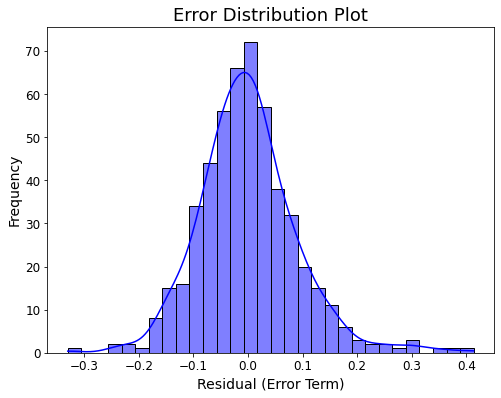

In [99]:
plt.figure(figsize=(8, 6))

# distribution plot for residuals
y_train_pred = lr_model.predict(X_train_sm)
residual = y_train_pred - y_train

sns.histplot(residual, kde=True, color='blue', bins=30)

# labels
plt.xlabel('Residual (Error Term)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Error Distribution Plot', fontsize=18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


- we can see error terms are normally distrubuted around 0 

## Error terms independence

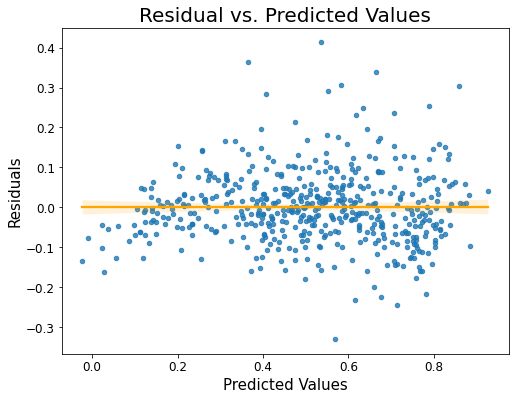

In [100]:
plt.figure(figsize=(8, 6))
sns.regplot(x=y_train_pred, y=residual, scatter_kws={'s': 20}, line_kws={'color': 'orange'})

plt.title('Residual vs. Predicted Values', fontsize=20)
plt.xlabel('Predicted Values', fontsize=15)
plt.ylabel('Residuals', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


- Residuals and Predicted values have almost no collinearity

## Homoescadicity

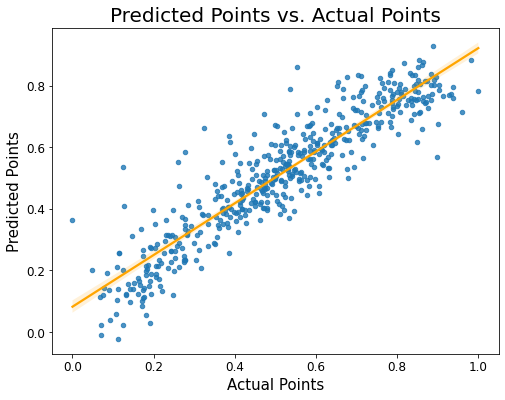

In [101]:
plt.figure(figsize=(8, 6))

# regression plot for predicted vs. actual points
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'s': 20}, line_kws={'color': 'orange'})

# add labels
plt.title('Predicted Points vs. Actual Points', fontsize=20)
plt.xlabel('Actual Points', fontsize=15)
plt.ylabel('Predicted Points', fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


- Residuals are equally distributed across predicted value.

## Predictions

In [102]:
df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])

In [103]:
y_test = df_test.pop('cnt')
X_test = df_test

In [104]:
X_test = X_test[X_train_rfe.columns] # taking only RFE chosen columns
X_test = sm.add_constant(X_test)

In [105]:
y_test_pred = lr_model.predict(X_test)

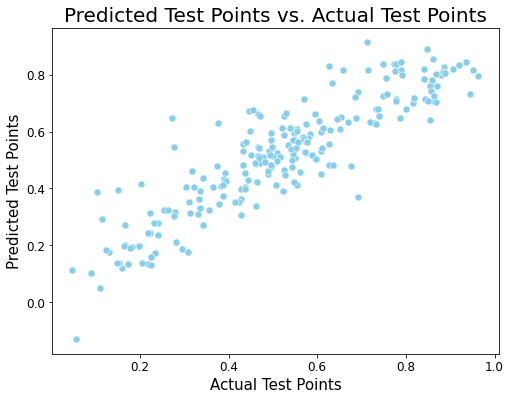

In [106]:
plt.figure(figsize=(8, 6))  # Set the figure size

# scatter plot for predicted vs. actual test points
sns.scatterplot(x=y_test, y=y_test_pred, color='skyblue', s=50)

# Adding labels 
plt.title('Predicted Test Points vs. Actual Test Points', fontsize=20)
plt.xlabel('Actual Test Points', fontsize=15)
plt.ylabel('Predicted Test Points', fontsize=15)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [107]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.7974599854948247

# Equation of the Multiple Linear Regression Fit Line

In [108]:
# Get the coefficients 
coefficients = lr_model.params

equation = f"Target Variable (cnt) = {coefficients['const']:.2f}"  # Start building the equation

for feature, coef in coefficients.items():
    if feature != 'const':  # skip intercept 
        equation += f" + {coef:.2f} * {feature}"

print("Equation of the fit line:")
print(equation)


Equation of the fit line:
Target Variable (cnt) = 0.09 + 0.10 * season_2 + 0.14 * season_4 + 0.23 * yr_1 + 0.05 * mnth_8 + 0.11 * mnth_9 + -0.06 * holiday_1 + 0.06 * weekday_6 + 0.05 * workingday_1 + -0.08 * weathersit_2 + -0.29 * weathersit_3 + 0.52 * temp + -0.15 * windspeed


==================================